# Fit RTs - AI and EA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from scipy import integrate
from numba import jit

from psiam_utils import rho_A_t_arr_fn, rho_E_t_arr_fn, cum_A_t_arr_fn, cum_E_t_arr_fn, rho_A_t_fn, rho_E_t_fn
from scipy.integrate import quad
from psiam_utils import simulate_psiam
from psiam_utils import rho_E_minus_t_arr_fn, cum_E_t_minus_arr_fn, rho_E_minus_t_fn

# Generate Data

In [2]:
V_A = 1; theta_A = 2; 
V_E = 0.5; theta_E = 1
Z_E = 0
t_stim = 0.5

N_sim = 10000
choices = np.zeros((N_sim, 1)); RTs = np.zeros((N_sim, 1)); is_act_resp = np.zeros((N_sim, 1))


def simulate_wrapper(V_A, theta_A, V_E, theta_E, Z_E, t_stim):
    return simulate_psiam(V_A, theta_A, V_E, theta_E, Z_E, t_stim)

results = Parallel(n_jobs=-1)(delayed(simulate_wrapper)(V_A, theta_A, V_E, theta_E, Z_E, t_stim) for _ in range(N_sim))

choices, RTs, is_act_resp = zip(*results)
choices = np.array(choices).reshape(-1, 1)
RTs = np.array(RTs).reshape(-1, 1)
is_act_resp = np.array(is_act_resp).reshape(-1, 1)

print(f'Num of act resp = {is_act_resp.sum()}/{N_sim}')
print(f'Number of aborts = {(RTs < t_stim).sum()}')

psiam_data = {'choices': choices, 'RTs': RTs, 'is_act_resp': is_act_resp, 'V_A': V_A, 'theta_A': theta_A, 'V_E': V_E, 'theta_E': theta_E, 't_stim': t_stim, 'Z_E': Z_E}


with open('psiam_data_5k_1.pkl', 'wb') as f:
    pickle.dump(psiam_data, f)

Num of act resp = 3752/10000
Number of aborts = 285


# Read data

In [2]:
with open('psiam_data_5k_1.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid]

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f"t start is {t_stim}")

V_A: 1
theta_A: 2
V_E: 0.5
theta_E: 1
Num of AI process: 3752/10000
t start is 0.5


# Plotting both P and CDF of AI and EA
Not sensible because a fraction of EA responses are taken by EA, and fraction of AI responses are taken by EA

<Axes: >

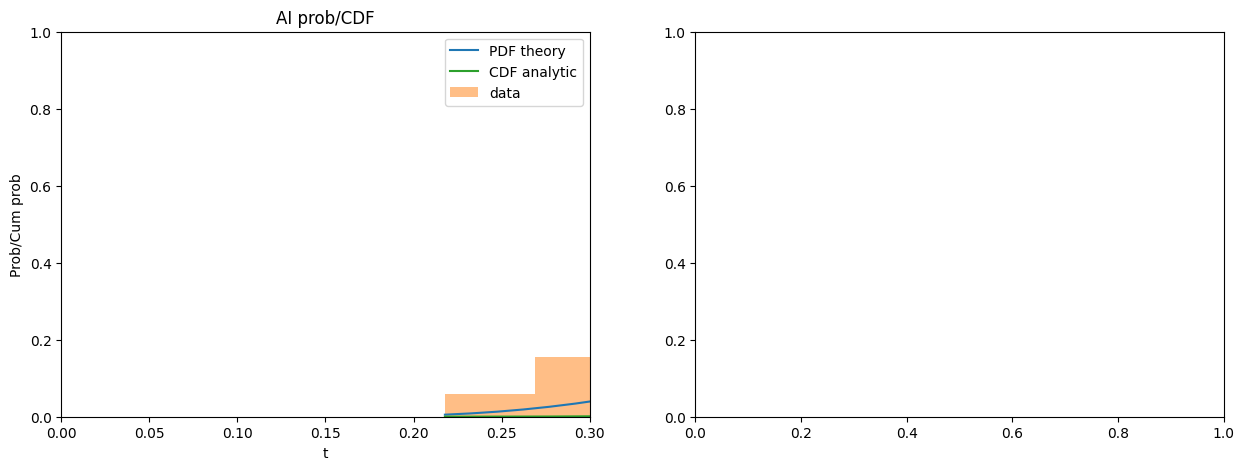

In [18]:
plt.figure(figsize=(15, 5))
# AI
RTs_act_flat = RTs_act.flatten()
t_pts = np.linspace(min(RTs_act_flat), 15, 1000)
# AI prob
norm_const, _ = quad(rho_A_t_fn, 0, np.inf, args=(V_A, theta_A))
rho_t_A_theory = rho_A_t_arr_fn(t_pts, V_A, theta_A)
rho_t_A_theory /= norm_const
plt.subplot(1,2,1)
plt.plot(t_pts, rho_t_A_theory);
# AI data
plt.hist(RTs_act_flat, bins=100, density=True, alpha=0.5);

# AI CDF
cum_A_t_theory = cum_A_t_arr_fn(t_pts, V_A, theta_A)
plt.plot(t_pts, cum_A_t_theory);
plt.ylim(0, 1);
plt.xlabel('t'); plt.ylabel('Prob/Cum prob');plt.title('AI prob/CDF');plt.legend(['PDF theory', 'CDF analytic', 'data']);
plt.xlim(0, 0.3)

# EA
plt.subplot(1,2,2)
# ---- TEMP ----
# with open('sample_rt.pkl', 'rb') as f:
#     RTs_evid_flat = pickle.load(f)

# V_E = 1.2; theta_E = 1
# --------------
min_val = 0.001

RTs_evid_flat = RTs_evid.flatten()

K_max = 50
t_pts = np.linspace(min_val, max(RTs_evid_flat), 1000)
rho_t_E_theory = rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max)
# norm_const, _ = quad(rho_E_t_fn, min(RTs_evid_flat), np.inf, args=(V_E, theta_E, K_max))
# rho_t_E_theory /= norm_const

# Data
plt.hist(RTs_evid_flat, density=True, bins=100, alpha=0.5);
# Custom histogram
# Normalize the histogram
# hist_values, bin_edges = np.histogram(RTs_evid_flat, bins=t_pts, density=True)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# plt.bar(bin_centers, hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='data')



# EA PDF
plt.plot(t_pts, rho_t_E_theory);
# EA cdf
cum_E_t_theory = cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, min_val)
plt.plot(t_pts, cum_E_t_theory);
plt.xlabel('t'); plt.ylabel('Prob/Cum prob');plt.title('EA prob/CDF');plt.legend(['PDF theory', 'CDF - PDF numeric integ', 'data']);

# Fit all RTs

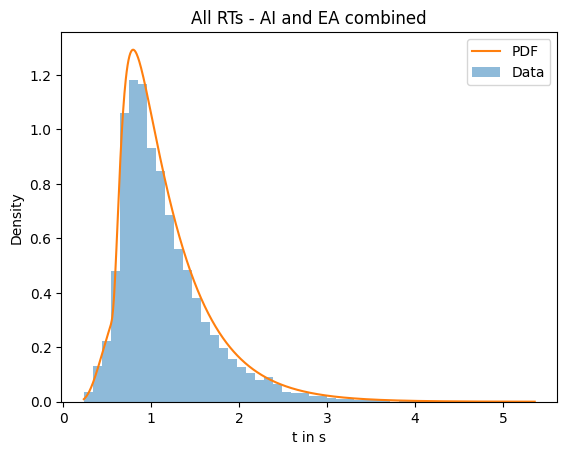

In [3]:
RTs_flat = RTs.flatten()
K_max = 50

# data
plt.hist(RTs_flat, density=True, bins=50, alpha=0.5);

# theory
t_pts = np.linspace(min(RTs_flat), max(RTs_flat), 1000)
P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
C_E = cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()

P_E = rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()
C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()

p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)

plt.plot(t_pts, p_theory)
plt.xlabel('t in s'); plt.ylabel('Density'); plt.title('All RTs - AI and EA combined');
plt.legend(['PDF', 'Data']);

# Fit correct and wrong trials RTs seperately

In [4]:
# theory
RTs_flat = RTs.flatten()

t_pts = np.linspace(min(RTs_flat), max(RTs_flat), 1000)
P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
C_E = cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()

P_E = rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()
C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()

This should not work because +1 and -1 also arise from AI processes, NOT only EA process

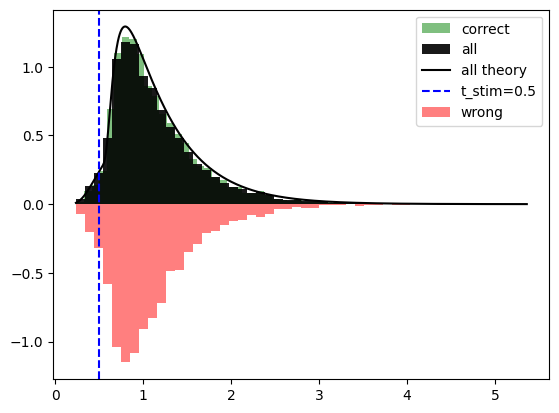

In [10]:
correct_idx = np.where(choices == 1)[0]
wrong_idx = np.where(choices == -1)[0]


correct_RT = RTs_flat[correct_idx]
wrong_RT = RTs_flat[wrong_idx]


plt.hist(correct_RT, bins=50, alpha=0.5, label='correct', color='g', density=True)
plt.hist(RTs_flat, bins=50, alpha=0.9, label='all', color='k', density=True);

wrong_hist, wrong_bins = np.histogram(wrong_RT, bins=50, density=True)
wrong_center = (wrong_bins[:-1] + wrong_bins[1:]) / 2
plt.bar(wrong_center, -wrong_hist, width=(wrong_bins[1] - wrong_bins[0]), alpha=0.5, label='wrong', color='r')


# all
p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)
plt.plot(t_pts, p_theory, color='k', label = 'all theory')

# correct- upper bound
# P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
# C_E = cum_E_t_minus_arr_fn(t_pts, -V_E, theta_E, K_max, t_stim).flatten()

# P_E = rho_E_minus_t_arr_fn(t_pts, -V_E, theta_E, K_max, t_stim).flatten()
# C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()

# p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)
# plt.plot(t_pts, p_theory, color='g', label = 'correct theory')


# wrong - lower bound
# P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
# C_E = cum_E_t_minus_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()

# P_E = rho_E_minus_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()
# C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()

# p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)
# plt.plot(t_pts, -1*p_theory, color='r', label = 'wrong theory')

plt.axvline(x=t_stim, color='blue', linestyle='--', label=f't_stim={t_stim}')


plt.legend();

# Rough work for integration

In [5]:
K_max = 50
c, _ = quad(rho_E_t_fn, 0.2, 0.3, args=(V_E, theta_E, K_max, t_stim))
print(f'integ from 0.1 to 1 = {c}')

integ from 0.1 to 1 = 0.0


# Rough temp

In [5]:
from psiam_utils import Phi

In [3]:
def P_x_small_t_fn(x, t, V_E, theta_E, Z, K_max):
    v = V_E
    a = 2*theta_E
    # mu = v*a
    mu = v*a
    
    Z = a * (Z + theta_E)/(2*theta_E) # [-1,1] system to [0,2] system

    term1 = 1/(4*np.pi*t)**0.5    
    k_terms = np.linspace(-K_max, K_max, 2*K_max+1)
    exp_1 = np.exp(4*mu*k_terms - (((x - Z - 4*k_terms - mu*t)**2)/(2*t)))
    exp_2 = np.exp(2*mu*(2 - 2*k_terms - Z) - ((x + Z + 4 - 4*k_terms - mu*t)**2)/(2*t))
    exp_diff = exp_1 - exp_2

    return term1*np.sum(exp_diff)

In [4]:
def P_x_large_t_fn(x, t, V_E, theta_E, Z, K_max):
    v = V_E
    a = 2*theta_E
    # mu = v*a
    mu = v*a

    Z = a * (Z + theta_E)/(2*theta_E)

    term1 = np.exp(mu*x - mu*Z)
    k_terms = np.arange(1, K_max+1)
    sine_term_1 = np.sin(k_terms * np.pi * Z/2)
    sine_term_2 = np.sin(k_terms * np.pi * x/2)
    exp_term = np.exp(-0.5 * (mu**2 + 0.25*(k_terms**2)*np.pi**2) * t)
    
    sum_term = np.sum(k_terms * sine_term_1 * sine_term_2 * exp_term)
    return term1 * sum_term

In [15]:
def S_E(t, V_E, theta_E, Z, K_max):
    v = V_E
    a = 2*theta_E
    mu = v*a
    Z = a * (Z + theta_E)/(2*theta_E)

    term1 = (np.pi/4) * np.exp(-mu*Z - 0.5*(mu**2)*t)
    k_terms = np.arange(1, K_max + 1)
    sine_term = 2*k_terms*np.sin(k_terms * np.pi * Z /2)
    exp_term_1 = 2 * k_terms * np.exp(2*mu) * np.sin(k_terms * np.pi *(2-Z)/2)
    exp_term_num = np.exp(-(1/8)*(k_terms**2)*(np.pi**2)*t)
    exp_term_deno = 1/((mu**2) + ((k_terms**2)*(np.pi**2))/4)
    
    sum_term = np.sum(sine_term * exp_term_1 * exp_term_num * exp_term_deno)

    if sum_term == 0:
        if np.sum(sine_term) == 0:
            raise ValueError(f"Sine term is zero ")
        if np.sum(exp_term_1) == 0:
            raise ValueError("Exp term 1 is zero")
        if np.sum(exp_term_num) == 0:
            raise ValueError("Exp term num is zero")
        if np.sum(exp_term_deno) == 0:
            raise ValueError("Exp term deno is zero")
        
        if sum_term == 0:
            raise ValueError("Sum term is zero")
    return term1 * sum_term


In [5]:
def P_x_t_fn(x, t, V_E, theta_E, Z, K_max, t_stim):
    if t <= t_stim:
        return 0
    t = t - t_stim
    if t > 0.25:
        return P_x_large_t_fn(x, t, V_E, theta_E, Z, K_max)
    else:
        return P_x_small_t_fn(x, t, V_E, theta_E, Z, K_max)

With using rho

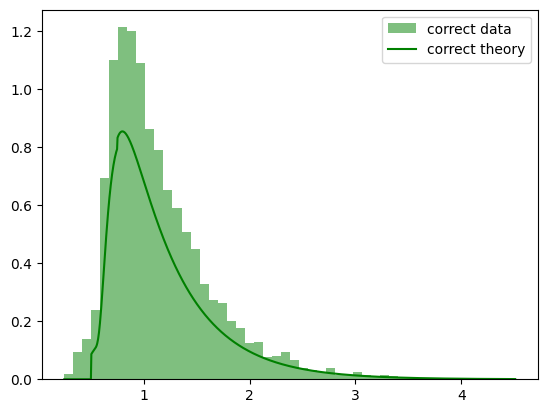

In [18]:
RTs_flat = RTs.flatten()

# data
correct_idx = np.where(choices == 1)[0]
correct_RT = RTs_flat[correct_idx]
t_pts = np.linspace(min(correct_RT), max(correct_RT), 1000)

plt.hist(correct_RT, bins=50, alpha=0.5, label='correct data', color='g', density=True)



# correct- upper bound
Z  = 0; K_max = 50

P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
C_E = cum_E_t_minus_arr_fn(t_pts, -V_E, theta_E, K_max, t_stim).flatten()

P_E = rho_E_minus_t_arr_fn(t_pts, -V_E, theta_E, K_max, t_stim).flatten()
C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()


P_EA_pos = np.zeros((len(t_pts)))
for i in range(len(t_pts)):
    P_EA_pos[i],_ =  quad(P_x_t_fn, 1, 2, args=(t_pts[i], V_E, theta_E, Z, K_max, t_stim))

# S_E_t = [S_E(t, V_E, theta_E, Z, K_max) for t in t_pts]    
P_EA_pos_norm = P_EA_pos

p_theory  = (P_A)*P_EA_pos_norm*(1 - C_E) + (P_E)*(1 - C_A)
# p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)

plt.plot(t_pts, p_theory, color='g', label = 'correct theory')
plt.legend();

With all Prob

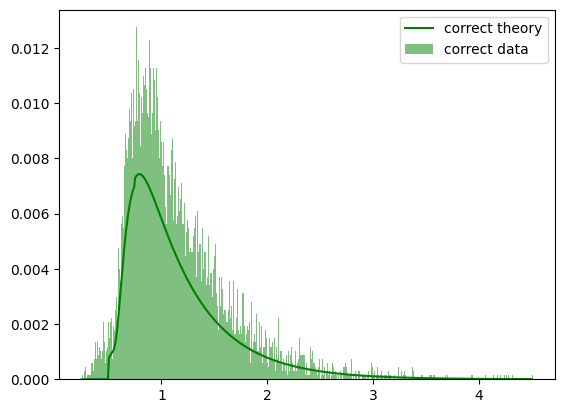

In [7]:
RTs_flat = RTs.flatten()

# data
correct_idx = np.where(choices == 1)[0]
correct_RT = RTs_flat[correct_idx]
t_pts = np.linspace(min(correct_RT), max(correct_RT), 500)

# ===
counts, bin_edges = np.histogram(correct_RT, bins=t_pts)
bin_width = bin_edges[1] - bin_edges[0]
counts = counts / (np.sum(counts))
plt.bar(t_pts[:-1], counts, width=bin_width, alpha=0.5, label='correct data', color='g', align='edge')
# ===


# correct- upper bound
Z  = 0; K_max = 50

# P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
P_A = np.zeros((len(t_pts)-1))
for i in range(len(t_pts)-1):
    P_A[i],_ =  quad(rho_A_t_fn, t_pts[i], t_pts[i+1], args=(V_A, theta_A))

C_E = cum_E_t_minus_arr_fn(t_pts, -V_E, theta_E, K_max, t_stim).flatten()
C_E = C_E[:-1] # to get size: T - 1

# P_E = rho_E_minus_t_arr_fn(t_pts, -V_E, theta_E, K_max, t_stim).flatten()
P_E = np.zeros((len(t_pts)-1))
for i in range((len(t_pts)-1)):
    P_E[i],_ =  quad(rho_E_minus_t_fn, t_pts[i], t_pts[i+1], args=(-V_E, theta_E, K_max, t_stim))

C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
C_A = C_A[:-1]

P_EA_pos = np.zeros((len(t_pts)-1))
for i in range(len(t_pts)-1):
    P_EA_pos[i],_ =  quad(P_x_t_fn, 1, 2, args=(t_pts[i], V_E, theta_E, Z, K_max, t_stim))

# S_E_t = [S_E(t, V_E, theta_E, Z, K_max) for t in t_pts]    
P_EA_pos_norm = P_EA_pos

p_theory  = (P_A)*P_EA_pos_norm*(1 - C_E) + (P_E)*(1 - C_A)
# p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)

plt.plot(t_pts[:-1], p_theory, color='g', label = 'correct theory')
plt.legend();

fit wrong RT

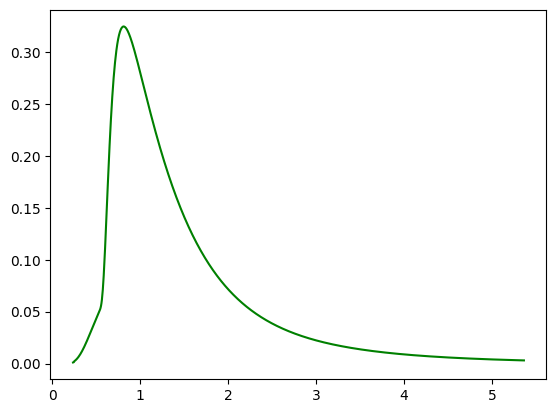

In [60]:
# wrong - upper bound
RTs_flat = RTs.flatten()

t_pts = np.linspace(min(RTs_flat), max(RTs_flat), 1000)
Z  = 0; K_max = 50

P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
C_E = cum_E_t_minus_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()

P_E = rho_E_minus_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()
C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()


P_EA_pos = np.zeros((len(t_pts)))
for i in range(len(t_pts)):
    P_EA_pos[i],_ =  quad(P_x_t_fn, 0, 1, args=(t_pts[i], V_E, theta_E, Z, K_max))

S_E_t = [S_E(t, V_E, theta_E, Z, K_max) for t in t_pts]

P_EA_pos_norm = P_EA_pos/S_E_t

p_theory  = (P_A)*P_EA_pos_norm*(1 - C_E) + (P_E)*(1 - C_A)
plt.plot(t_pts, p_theory, color='g', label = 'correct theory')